# Integrating Product Design and Supply Chain Design

## Import Packages

In [220]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import gurobipy as gp
from gurobipy import GRB
from gurobipy import quicksum as qsum
import pandas as pd
from pandas import DataFrame, read_csv
import random
import math

# import sys
# sys.path.append('../')
# import saedfsc;

## Parameters

In [221]:
multiEchelon = True
if multiEchelon:
    numAssemblies = 2
    numComponentsPerAssembly = 2
    numComponents = numAssemblies * numComponentsPerAssembly
else:
    numComponents = 2

numSuppliers = 4
numAssemblyOptions = 2
numPartOptionsForComponent = 2
numSuppliersPerPart = 2

timeUB = 3

In [222]:
numTiers = 2

np.random.seed(0)

In [223]:
# if not multiEchelon:
#     assemblyNodes = []
#     components = list(range(1, numComponents + 1))
#     assembliesStructure = {c : [] for c in components}
# else:
#     components = []
#     assemblyNodes = []
#     componentID = 1
#     assembliesStructure = {}
#     for i in range(numComponents + 1, numComponents + numAssemblies + 1):
#         assemblyNodes.append(i)
#         assembliesStructure[i] = []
#         for j in range(1, numComponentsPerAssembly + 1):
#             components.append(componentID)
#             assembliesStructure[i].append(componentID)
#             componentID += 1
# finalNode = numComponents + len(assemblyNodes) + 1
# finalNodes = [finalNode]
# allNodes = components + assemblyNodes + [finalNode]
# nonComponentNodes = assemblyNodes + [finalNode]

## BOM: Components

In [224]:
# G = nx.DiGraph()

# numNodes = len(components) + len(assemblyNodes) + len(finalNodes)

# np.random.seed(0)
# maxServiceTimeOutList = 20*np.ones(numNodes)
# maxServiceTimeOutList[numNodes-1] = 0

# for n in allNodes:
#     time = np.random.randint(1, timeUB)
#     if n in finalNodes:
#         maxTime = 0
#     else:
#         maxTime = 100
#     G.add_node(n, process_time=time, 
#                max_service_time_out=maxTime,
#                stage_cost=np.random.randint(1, 6))

# if multiEchelon is False:
#     for n in components:
#         for n2 in finalNodes:
#             G.add_edge(n, n2)
# else:
#     for n in assemblyNodes:
#         G.add_edge(n, finalNode)
#         for component in assembliesStructure[n]:
#             G.add_edge(component, n)
#             # for partOption in range(1, numPartOptionsForComponent + 1):
#             #     time = np.random.randint(1, timeUB)
#             #     partOptionNode = str(component) + "-" + str(partOption)
#             #     G.add_node(partOptionNode, process_time=time, 
#             #     max_service_time_out=100,
#             #     stage_cost=np.random.randint(1, 6))
#             #     G.add_edge(partOptionNode, component)

# maxServiceTimeOut = nx.get_node_attributes(G, 'max_service_time_out')
# processTimesDict = nx.get_node_attributes(G, 'process_time')
# stageCostDict = nx.get_node_attributes(G, 'stage_cost')
# maxServiceTimeOut = nx.get_node_attributes(G, 'max_service_time_out')

# node_labels = {node: node for node in G.nodes()}
# pos = nx.spring_layout(G)
# nx.draw(G, pos, labels = node_labels, with_labels=True, node_size=2000)
# plt.show()

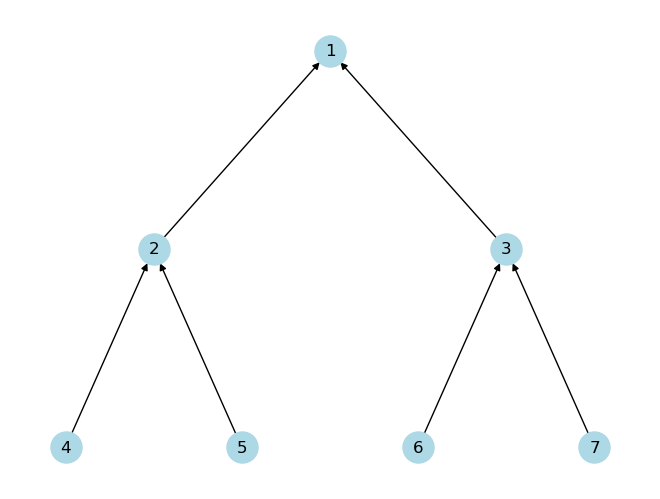

In [225]:
def buildBOMGraph():

    def add_edges(G, node, depth, pos, x=0, y=0, dx=1):
        pos[node] = (x, y)
        G.nodes[node]['depth'] = depth
        #print(node, G.nodes[node])
        if depth > 0:
            node_left = node*2
            node_right = node*2 + 1
            G.add_edge(node_left, node)
            G.add_edge(node_right, node)
            add_edges(G, node_left, depth-1, pos, x-dx, y-1, dx/2)
            add_edges(G, node_right, depth-1, pos, x+dx, y-1, dx/2)

    G = nx.DiGraph()
    root_node = 1
    pos = {}
    G.add_node(root_node, depth = 2, tier = 0)
    #print(G.nodes(data=True))
    add_edges(G, root_node, 2, pos)
    for i in G.nodes():
        time = np.random.randint(1, timeUB)
        if i == root_node:
            maxTime = 0
        else:
            maxTime = 100
        G.nodes[i]['process_time'] = time
        G.nodes[i]['max_service_time_out'] = maxTime
        G.nodes[i]['stage_cost'] = np.random.randint(1, 6)
        G.nodes[i]['tier'] = numTiers - G.nodes[i]['depth']
    return G, pos

bomGraph, bomGraphPos = buildBOMGraph()
nx.draw(bomGraph, bomGraphPos, with_labels=True, node_color='lightblue', node_size=500)
plt.show()

maxServiceTimeOut = nx.get_node_attributes(bomGraph, 'max_service_time_out')
processTimesDict = nx.get_node_attributes(bomGraph, 'process_time')
stageCostDict = nx.get_node_attributes(bomGraph, 'stage_cost')
maxServiceTimeOut = nx.get_node_attributes(bomGraph, 'max_service_time_out')

In [226]:
# pos = {}
# numTiers = 3
# horizDist = 5
# slopes = [1, -1]
# descendentsPerNode = 2

# def buildBOMGraph(G, root):
#     newX = pos[root][0] + horizDist
#     yBase = pos[root][1]
#     newNodeID = root + 1
#     currentTier = G.nodes[root]['tier']
#     index = 0
#     for d in range(descendentsPerNode):
#         G.add_edge(root, newNodeID)
#         print("edge", root, newNodeID)
#         G.add_node(newNodeID, tier = currentTier + 1)
#         print(newNodeID, currentTier + 1)
#         pos[newNodeID] = [newX, yBase + horizDist*slopes[index]]
#         if currentTier < numTiers - 1:
#             buildBOMGraph(G, newNodeID)
#         newNodeID += 1
#         index += 1

In [227]:
# bomGraph = nx.DiGraph()
# bomGraph.add_node(1, tier = 0)
# pos[1] = [0, 0]
# buildBOMGraph(bomGraph, 1, 1)

# node_labels = {node: node for node in bomGraph.nodes()}
# nx.draw(bomGraph, pos, labels = node_labels, with_labels=True, node_size=2000)
# plt.show()

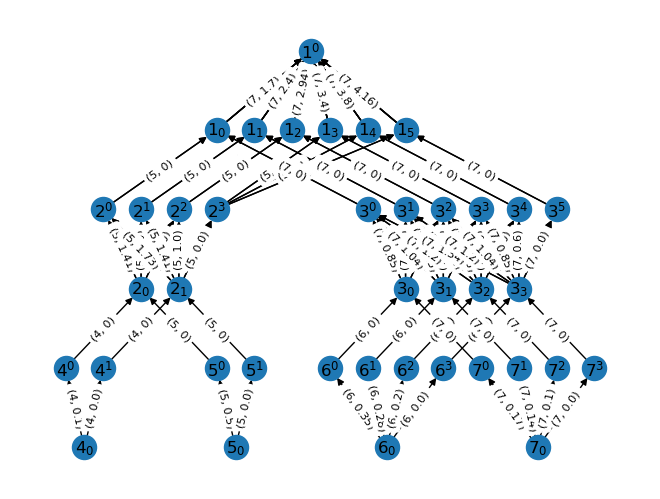

[('1_0', '1^0', {'intime': 0, 'outtime': 0, 'cost': 1.7000000000000002, 'type': 'net-time', 'part': 4}), ('1_0', '1^0', {'intime': 0, 'outtime': 0, 'cost': 1.7000000000000002, 'type': 'net-time', 'part': 5}), ('1_0', '1^0', {'intime': 0, 'outtime': 0, 'cost': 1.7000000000000002, 'type': 'net-time', 'part': 6}), ('1_0', '1^0', {'intime': 0, 'outtime': 0, 'cost': 1.7000000000000002, 'type': 'net-time', 'part': 7}), ('1_1', '1^0', {'intime': 1, 'outtime': 0, 'cost': 2.404163056034262, 'type': 'net-time', 'part': 4}), ('1_1', '1^0', {'intime': 1, 'outtime': 0, 'cost': 2.404163056034262, 'type': 'net-time', 'part': 5}), ('1_1', '1^0', {'intime': 1, 'outtime': 0, 'cost': 2.404163056034262, 'type': 'net-time', 'part': 6}), ('1_1', '1^0', {'intime': 1, 'outtime': 0, 'cost': 2.404163056034262, 'type': 'net-time', 'part': 7}), ('1_2', '1^0', {'intime': 2, 'outtime': 0, 'cost': 2.9444863728670914, 'type': 'net-time', 'part': 4}), ('1_2', '1^0', {'intime': 2, 'outtime': 0, 'cost': 2.94448637286709

In [ ]:
def createExtendedMultiGraph(extGraph : nx.DiGraph):
    G = nx.MultiDiGraph()
    G.add_nodes_from(extGraph.nodes(data=True))
    for e in extGraph.edges(data = True):
        id = extGraph.nodes[e[0]]['id']
        for p in get_descendent_parts(bomGraph, id):
            attrDict = e[2]
            intime = attrDict['intime']
            outtime = attrDict['outtime']
            attrDict['part'] = p
            G.add_edge(e[0], e[1], **attrDict)
    return G

extMultiGraph = createExtendedMultiGraph(extGraph)

node_labels = {node: r'$' +node + '$' for node in extMultiGraph.nodes()}
nx.draw(extMultiGraph, newPos, labels = node_labels, with_labels=True)
edge_labels = {(u, v): (data['part'], round(data['cost'],2)) 
              for u, v, data in extMultiGraph.edges(data=True)}
nx.draw_networkx_edge_labels(extMultiGraph, newPos, edge_labels=edge_labels, font_size=8)
plt.show()
print(extMultiGraph.edges(data=True))

In [228]:
safetyFactor = 1.645
sigma = 3
holdingCostRate = 0.2

In [229]:
# def getMaxReplenishmentTime(G : nx.DiGraph, n : int):
#     if n in components:
#         return processTimesDict[n]
#     else:
#         return processTimesDict[n] + max([getMaxReplenishmentTime(i) for i in G.predecessors(n)])
    
# def getCumCost(G : nx.DiGraph, n : int):
#     if n in components:
#         return stageCostDict[n]
#     else:
#         return stageCostDict[n] + sum([getCumCost(i) for i in G.predecessors(n)])
    
def getMaxReplenishmentTime(G : nx.DiGraph, n : int):
    #if n in components:
    if G.nodes[n]['tier'] == numTiers:
        return processTimesDict[n]
    else:
        return processTimesDict[n] + max([getMaxReplenishmentTime(G, i) for i in G.predecessors(n)])
    
def getCumCost(G : nx.DiGraph, n : int):
    if G.nodes[n]['tier'] == numTiers:
        return stageCostDict[n]
    else:
        return stageCostDict[n] + sum([getCumCost(G, i) for i in G.predecessors(n)])

print(bomGraph.nodes(data=True))
maxReplenishmentTime = {n : getMaxReplenishmentTime(bomGraph, n) for n in bomGraph.nodes()}
cumCost = {n : getCumCost(bomGraph, n) for n in bomGraph.nodes()}

df = pd.DataFrame({
    'Node': maxReplenishmentTime.keys(),
    'Process time': processTimesDict.values(),
    'Stage cost': stageCostDict.values(),
    'Cumulative cost': cumCost.values(),
    'Max time': maxServiceTimeOut.values(),
    'maxReplenishmentTime': maxReplenishmentTime.values()
})
df.to_csv('instance.csv')
df

[(1, {'depth': 2, 'tier': 0, 'process_time': 1, 'max_service_time_out': 0, 'stage_cost': 1}), (2, {'depth': 1, 'process_time': 2, 'max_service_time_out': 100, 'stage_cost': 4, 'tier': 1}), (3, {'depth': 1, 'process_time': 2, 'max_service_time_out': 100, 'stage_cost': 2, 'tier': 1}), (4, {'depth': 0, 'process_time': 2, 'max_service_time_out': 100, 'stage_cost': 3, 'tier': 2}), (5, {'depth': 0, 'process_time': 1, 'max_service_time_out': 100, 'stage_cost': 1, 'tier': 2}), (6, {'depth': 0, 'process_time': 1, 'max_service_time_out': 100, 'stage_cost': 5, 'tier': 2}), (7, {'depth': 0, 'process_time': 1, 'max_service_time_out': 100, 'stage_cost': 2, 'tier': 2})]


,Node,Process time,Stage cost,Cumulative cost,Max time,maxReplenishmentTime
0,1,1,1,18,0,5
1,2,2,4,8,100,4
2,3,2,2,9,100,3
3,4,2,3,3,100,2
4,5,1,1,1,100,1
5,6,1,5,5,100,1
6,7,1,2,2,100,1


In [230]:
def get_sIn_range_for_g_fn(node : int):
    maxVal = maxReplenishmentTime[node] - processTimesDict[node]
    return range(maxVal + 1)

def get_sOut_range_for_g_fn_forIn(G : nx.DiGraph, node : int, sIn : int):
    maxVal = sIn + processTimesDict[node]
    if G.nodes[node]['tier'] < numTiers:
        maxVal = min(maxVal, maxServiceTimeOut[node])
    return range(maxVal+1)

def get_sOut_range_for_g_fn_all(G : nx.DiGraph,node : int):
    vals = set()
    for sIn in get_sIn_range_for_g_fn(node):
        vals = vals.union(set(get_sOut_range_for_g_fn_forIn(G, node, sIn)))
        #print(sIn, vals)
    return vals

# def get_sOut_rangeForIn(node : int, sIn : int = 0):
#     return range(sIn + processTimesDict[node]+ 1)

def get_possible_sin_for_sout_at_pred(node : int, sOut_at_pred : int, maxSOut_at_pred : int):
    if sOut_at_pred == maxSOut_at_pred:
        return [sIn for sIn in get_sIn_range_for_g_fn(node) if sIn >= sOut_at_pred]
    else:
        return [sOut_at_pred]

def getHoldingCost(node : int, sIn : int, sOut : int):
    return safetyFactor*sigma*holdingCostRate*cumCost[node]*np.sqrt(sIn + processTimesDict[node] - sOut)

def getNodeString(node : int, s : int, isOut : bool):
    if isOut:
        return "{}^{}".format(node, s)
    else:
        return "{}_{}".format(node, s)
    
def getNodeStringOption(node : int, option : int):
    return "{}^{}".format(node, option)

In [231]:
def convertToExtendedGraph(bomGraph : nx.DiGraph, pos : dict, yOffSet = 0.25):
    G = nx.DiGraph()
    newPos = {}
    xIncr = 0.4
    for i in bomGraph.nodes():
        xOffSet = -1
        for sIn in get_sIn_range_for_g_fn(i):
            inNodeStr = getNodeString(i, sIn, False)
            #print(i, inNodeStr)
            G.add_node(inNodeStr, process_time=0, 
               max_service_time_out=0,
               stage_cost=0)
            newPos[inNodeStr] = (pos[i][0] + xOffSet, pos[i][1] - yOffSet)
            xOffSet += xIncr
        xOffSet = -1
        for sOut in get_sOut_range_for_g_fn_all(bomGraph, i):
            outNodeStr = getNodeString(i, sOut, True)
            G.add_node(outNodeStr, process_time=0, 
               max_service_time_out=0,
               stage_cost=0)
            newPos[outNodeStr] = (pos[i][0] + xOffSet, pos[i][1] + yOffSet)
            xOffSet += xIncr
        for sIn in get_sIn_range_for_g_fn(i):
            for sOut in get_sOut_range_for_g_fn_forIn(bomGraph, i, sIn):
                nodeTupleIn = getNodeString(i, sIn, False)
                nodeTupleOut = getNodeString(i, sOut, True)
                G.add_edge(nodeTupleIn, nodeTupleOut, 
                            cost = getHoldingCost(i, sIn, sOut))
    for (i,j) in bomGraph.edges():
        maxSOut_at_pred = max(get_sOut_range_for_g_fn_all(bomGraph, i))
        for sOut in get_sOut_range_for_g_fn_all(bomGraph, i):
            for sIn in get_possible_sin_for_sout_at_pred(j, sOut, maxSOut_at_pred):
                nodeTupleOut = getNodeString(i, sOut, True)
                nodeTupleIn = getNodeString(j, sIn, False)
                G.add_edge(nodeTupleOut, nodeTupleIn, 
                                cost = 0)
    return G, newPos

1^0
2^0
2^1
2^2
2^3
2^4
3^0
3^1
3^2
3^3
4^0
4^1
4^2
5^0
5^1
6^0
6^1
7^0
7^1
{'1_0': (-1, -0.25), '1_1': (-0.6, -0.25), '1_2': (-0.19999999999999996, -0.25), '1_3': (0.20000000000000007, -0.25), '1_4': (0.6000000000000001, -0.25), '1^0': (-1, 0.25), '2_0': (-2, -1.25), '2_1': (-1.6, -1.25), '2_2': (-1.2, -1.25), '2^0': (-2, -0.75), '2^1': (-1.6, -0.75), '2^2': (-1.2, -0.75), '2^3': (-0.7999999999999999, -0.75), '2^4': (-0.3999999999999999, -0.75), '3_0': (0, -1.25), '3_1': (0.4, -1.25), '3^0': (0, -0.75), '3^1': (0.4, -0.75), '3^2': (0.8, -0.75), '3^3': (1.2000000000000002, -0.75), '4_0': (-2.5, -2.25), '4^0': (-2.5, -1.75), '4^1': (-2.1, -1.75), '4^2': (-1.7, -1.75), '5_0': (-1.5, -2.25), '5^0': (-1.5, -1.75), '5^1': (-1.1, -1.75), '6_0': (-0.5, -2.25), '6^0': (-0.5, -1.75), '6^1': (-0.09999999999999998, -1.75), '7_0': (0.5, -2.25), '7^0': (0.5, -1.75), '7^1': (0.9, -1.75)}


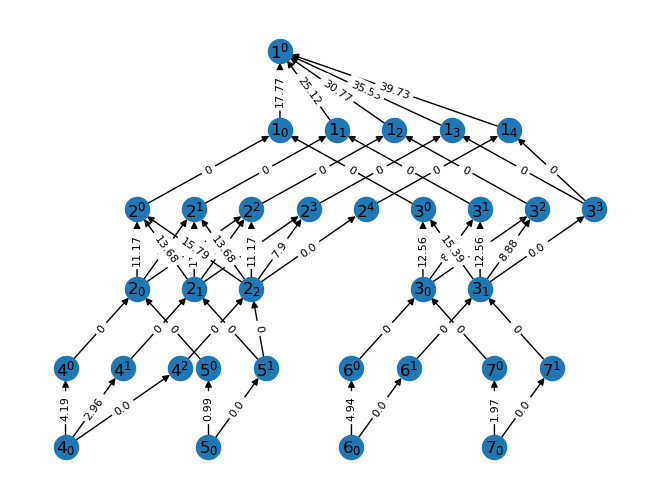

In [232]:
extGraph, newPos = convertToExtendedGraph(bomGraph, bomGraphPos)
node_labels = {node: r'$' +node + '$' for node in extGraph.nodes()}
nx.draw(extGraph, newPos, labels = node_labels, with_labels=True)
edge_labels = {(u, v): round(data['cost'],2) 
              for u, v, data in extGraph.edges(data=True)}
nx.draw_networkx_edge_labels(extGraph, newPos, edge_labels=edge_labels, font_size=8)
plt.show()

In [233]:
# def build_dp_graph(G : nx.DiGraph, root):
#     if G.nodes[root]['type'] == 'out':
#         id = G.nodes[root]['id']
#         for partOption in range(1, numPartOptionsForComponent + 1):
#             nodeStr = getNodeStringOption(id, partOption)
#             G.add_node(nodeStr, type = 'partOption', id = id)
#             G.add_edge(root, nodeStr, cost = 0)
#             build_dp_graph(G, nodeStr, 
#                            cost = getHoldingCost(int(G.nodes[root]['id']), sIn, G.nodes[root]['stime']))
#     if G.nodes[root]['type'] == 'partOption':
#         id = G.nodes[root]['id']
#         for sIn in get_sIn_range_for_g_fn(id):
#             nodeStr = getNodeString(id, sIn, False)
#             G.add_node(nodeStr, type = 'in', stime = sIn)
#             G.add_edge(nodeStr, root,
#                                 commodity = component, 
#                                 cost = 0)

# dp_G = nx.DiGraph()
# root = 7
# rootNodeStr = getNodeString(root, 0, True)
# dp_G.add_node(rootNodeStr, id = root, type = 'out', stime = 0)

# build_dp_graph(dp_G, rootNodeStr)

# node_labels = {node: r'$' +node + '$' for node in dp_G.nodes()}
# pos = nx.spring_layout(dp_G)
# nx.draw(dp_G, pos, labels = node_labels, with_labels=True)
# nx.draw(dp_G, pos)
# edge_labels = {(u, v): round(data['cost'],2) 
#               for u, v, data in dp_G.edges(data=True)}
# nx.draw_networkx_edge_labels(dp_G, pos, edge_labels=edge_labels, font_size=8)
# plt.show()

In [234]:
# def create_dp_graph(G : nx.DiGraph, multi_commod : bool = False):
#     if multi_commod:
#         dp_G = nx.MultiDiGraph()
#     else:
#         dp_G = nx.DiGraph()
#     finalNode = finalNodes[0]
#     for sIn in get_sIn_range_for_g_fn(finalNode):
#         nodeTupleIn = getNodeString(finalNode, sIn, False)
    #     #if multi_commod:
    #     dp_G.add_node(nodeTupleIn, nodeType = 'multi-component')
    #     # else:
    #     #     dp_G.add_node(nodeTupleIn)
    # for sOut in get_sOut_range_for_g_fn_all(finalNode):
    #     nodeTupleOut = getNodeString(finalNode, sOut, True)
    #     #if multi_commod:
    #     dp_G.add_node(nodeTupleOut, nodeType = 'multi-component')
    #     # else:
    #     #     dp_G.add_node(nodeTupleOut)
    #     for sIn in get_sIn_range_for_g_fn(finalNode):
    #         nodeTupleIn2 = getNodeString(finalNode, sIn, False)
    #         if multi_commod:
    #             for component in components:
    #                 dp_G.add_edge(nodeTupleIn2, nodeTupleOut,
    #                             commodity = component, 
    #                             cost = getHoldingCost(finalNode, sIn, sOut))
    #         else:
    #             dp_G.add_edge(nodeTupleIn2, nodeTupleOut, 
    #                        cost = getHoldingCost(finalNode, sIn, sOut))
                
    # for n in assembliesStructure:
    #     for sIn in get_sIn_range_for_g_fn(n):
    #         nodeTupleIn = getNodeString(n, sIn, False)
    #         #if multi_commod:
    #         dp_G.add_node(nodeTupleIn, nodeType = 'multi-component')
    #         # else:
    #         #     dp_G.add_node(nodeTupleIn)
    #     for sOut in get_sOut_range_for_g_fn_all(n):
    #         #print(n, "sIn", sIn, "sOut", sOut)
    #         nodeTupleOut = getNodeString(n, sOut, True)
    #         finalNodeTupleIn = getNodeString(finalNode, sOut, False)
    #         dp_G.add_node(nodeTupleOut, nodeType = 'multi-component')
    #         if multi_commod:
    #             if multiEchelon:
    #                 for component in assembliesStructure[n]:
    #                     #print("add", nodeTupleOut, finalNodeTupleIn, component)
    #                     dp_G.add_edge(nodeTupleOut, finalNodeTupleIn, 
    #                                 commodity = component,
    #                                     cost = 0)
    #             else:
    #                 dp_G.add_edge(nodeTupleOut, finalNodeTupleIn, 
    #                                 commodity = n,
    #                                     cost = 0)
    #         else:
    #             #dp_G.add_node(nodeTupleOut)
    #             dp_G.add_edge(nodeTupleOut, finalNodeTupleIn, 
    #                             cost = 0)
    #     for sIn in get_sIn_range_for_g_fn(n):
    #         for sOut in get_sOut_range_for_g_fn_forIn(n, sIn):
    #             nodeTupleIn = getNodeString(n, sIn, False)
    #             nodeTupleOut = getNodeString(n, sOut, True)
    #             if multi_commod:
    #                 if multiEchelon:
    #                     for component in assembliesStructure[n]:
    #                         dp_G.add_edge(nodeTupleIn, nodeTupleOut, 
    #                                     commodity = component,
    #                                     cost = getHoldingCost(n, sIn, sOut))
    #                 else:
    #                     dp_G.add_edge(nodeTupleIn, nodeTupleOut, 
    #                                     commodity = n,
    #                                     cost = getHoldingCost(n, sIn, sOut))
    #             else:
    #                 dp_G.add_edge(nodeTupleIn, nodeTupleOut, 
    #                             cost = getHoldingCost(n, sIn, sOut))
                
    #     for component in assembliesStructure[n]:
    #         for partOption in range(1, numPartOptionsForComponent + 1):
    #             partOptionNode = str(component) + "-" + str(partOption)
    #             dp_G.add_node(partOptionNode, nodeType = 'component')
    #             for sIn in get_sIn_range_for_g_fn(component):
    #                 nodeTupleIn = getNodeString(component, sIn, False)
    #                 dp_G.add_node(nodeTupleIn, nodeType = 'component')
    #         for sOut in get_sOut_range_for_g_fn_all(component):
    #             nodeTupleOut = getNodeString(component, sOut, True)
    #             assemblyNodeTupleIn = getNodeString(n, sOut, False)
    #             dp_G.add_node(nodeTupleOut, nodeType = 'component')
    #             if multi_commod:
    #                 dp_G.add_edge(nodeTupleOut, assemblyNodeTupleIn, 
    #                                   commodity = component,
    #                                 cost = 0)
    #             else:
    #                 dp_G.add_edge(nodeTupleOut, assemblyNodeTupleIn, 
    #                                 cost = 0)
    #         for sIn in get_sIn_range_for_g_fn(component):
    #             nodeTupleIn = getNodeString(component, sIn, False)
    #             for partOption in range(1, numPartOptionsForComponent + 1):
    #                 partOptionNode = str(component) + "-" + str(partOption)
    #                 dp_G.add_edge(partOptionNode, nodeTupleIn, 
    #                                 cost = 0)
    #             for sOut in get_sOut_range_for_g_fn_forIn(component, sIn):
    #                 nodeTupleOut = getNodeString(component, sOut, True)
    #                 if multi_commod:
    #                     dp_G.add_edge(nodeTupleIn, nodeTupleOut, 
    #                                   commodity = component,
    #                                 cost = getHoldingCost(component, sIn, sOut))
    #                 else:
    #                     dp_G.add_edge(nodeTupleIn, nodeTupleOut, 
    #                                 cost = getHoldingCost(component, sIn, sOut))
                        
    # return dp_G

In [235]:
# def get_dp_layout(G : nx.DiGraph):
#     pos = nx.spring_layout(G)
#     finalNode = finalNodes[0]
#     xVal = 1.5
#     yVal = 1.5
#     for sOut in get_sOut_range_for_g_fn_all(finalNode):
#         nodeTupleOut = getNodeString(finalNode, sOut, True)
#         pos[nodeTupleOut] = np.array([0, yVal])
#     xVal = 0
#     xDec = 0.75
#     yVal -= 0.5
#     for sIn in get_sIn_range_for_g_fn(finalNode):
#         nodeTupleIn = getNodeString(finalNode, sIn, False)
#         pos[nodeTupleIn] = np.array([xVal, yVal])
#         xVal += xDec
#     xVal = 0
#     yVal -= 0.4
#     for n in assembliesStructure:
#         for sOut in get_sOut_range_for_g_fn_all(n):
#             nodeTupleOut = getNodeString(n, sOut, True)
#             pos[nodeTupleOut] = np.array([xVal, yVal])
#             xVal += 0.5
#     xVal = 0
#     xDec = 0.75
#     yVal -= 0.75
#     for n in assembliesStructure:
#         for sIn in get_sIn_range_for_g_fn(n):
#             nodeTupleIn = getNodeString(n, sIn, False)
#             pos[nodeTupleIn] = np.array([xVal, yVal])
#             xVal += xDec
#     xVal = 0
#     yVal -= 0.25
#     for n in assembliesStructure:
#         for component in assembliesStructure[n]:
#                 for sOut in get_sOut_range_for_g_fn_all(component):
#                     nodeTupleOut = getNodeString(component, sOut, True)
#                     pos[nodeTupleOut] = np.array([xVal, yVal])
#                     xVal += 0.5
#     xVal = 0
#     xDec = 1
#     yVal -= 0.5
#     for n in assembliesStructure:
#         for component in assembliesStructure[n]:
#                 for sIn in get_sIn_range_for_g_fn(component):
#                     nodeTupleIn = getNodeString(component, sIn, False)
#                     pos[nodeTupleIn] = np.array([xVal, yVal])
#                     xVal += xDec
#     xVal = 0
#     xDec = 0.5
#     yVal -= 0.5
#     for n in assembliesStructure:
#         for component in assembliesStructure[n]:
#                 for partOption in range(1, numPartOptionsForComponent + 1):
#                     partOptionNode = str(component) + "-" + str(partOption)
#                     pos[partOptionNode] = np.array([xVal, yVal])
#                     xVal += xDec
    
#     return pos

In [236]:
# dp_G = create_dp_graph(G)
# node_labels = {node: r'$' +node + '$' for node in dp_G.nodes()}
# pos = get_dp_layout(dp_G)
# nx.draw(dp_G, pos, labels = node_labels, with_labels=True)
# edge_labels = {(u, v): round(data['cost'],2) 
#                for u, v, data in dp_G.edges(data=True)}
# nx.draw_networkx_edge_labels(dp_G, pos, edge_labels=edge_labels, 
#                              font_size=8)
# plt.show()

In [237]:
def getNetFlowExpr(G, x, node):
    return qsum(x[e] for e in G.out_edges(node)) - qsum(x[e] for e in G.in_edges(node))

finalNodeStr = str(finalNode) + '^0'
startNodes = [str(n) + '_0' for n in components]

nodeTypes = nx.get_node_attributes(dp_G, 'nodeType')
multicommodNodes = [n for n in dp_G.nodes() if nodeTypes[n] == 'multi-component']

def getAllMultiCommodInEdges():
    for n in multicommodNodes:
        for e in dp_G.in_edges(n):
            yield e

def getNetFlowExprRHS(n):
    if n in startNodes:
        return 1
    elif n == finalNodeStr:
        return -len(startNodes)
    else:
        return 0

NameError: name 'dp_G' is not defined

In [ ]:
def getOptimizedShortestPathModel(vtypeY = GRB.BINARY, log = False):
    m = gp.Model("shortest_path")
    m.Params.LogToConsole = log

    flowEdges = dp_G.edges() - dp_G.in_edges(finalNodeStr)

    x = m.addVars(dp_G.edges(), name="x")
    y = m.addVars(getAllMultiCommodInEdges(), name="y", vtype=vtypeY)
    m._x = x
    m._y = y

    m.setObjective(qsum(x[e]*dp_G.edges[e]['cost'] for e in flowEdges) + 
                qsum(y[e]*dp_G.edges[e]['cost'] for e in y), 
                GRB.MINIMIZE)

    m.addConstrs((x[e] <= numComponents*y[e] for e in y), "UB")
    m.addConstrs((getNetFlowExpr(dp_G, x, n) == getNetFlowExprRHS(n) 
                for n in dp_G.nodes()), "netflow")

    m.optimize()
    m.write('shortest_path.lp')
    return m

m = getOptimizedShortestPathModel(vtypeY = GRB.CONTINUOUS)
print("Relaxed Cost: $", format(m.ObjVal, ",.2f"))
m = getOptimizedShortestPathModel(log = False)
print("Optimal Cost: $", format(m.ObjVal, ",.2f"))
xVals = [m._x[e].x for e in m._x if m._x[e].x > 0.0]
edgesUsed = list({(e[0], e[1]) for e in m._x if m._x[e].x > 0.0})
costs = [dp_G.edges[e]['cost'] for e in edgesUsed]

df = pd.DataFrame({
    'Edge used': edgesUsed,
    'Holding cost': costs
})
df['Holding cost'] = df['Holding cost'].map('${:,.2f}'.format)
df

Relaxed Cost: $ 33.92
Optimal Cost: $ 38.67


,Edge used,Holding cost
0,"(5_0, 5^1)",$0.00
1,"(3_0, 3^0)",$2.79
2,"(2_0, 2^0)",$5.58
3,"(1_0, 1^0)",$0.99
4,"(3^0, 6_0)",$0.00
5,"(7_1, 7^0)",$25.12
6,"(6_0, 6^1)",$0.00
7,"(4_0, 4^0)",$4.19
8,"(1^0, 5_0)",$0.00
9,"(4^0, 6_0)",$0.00


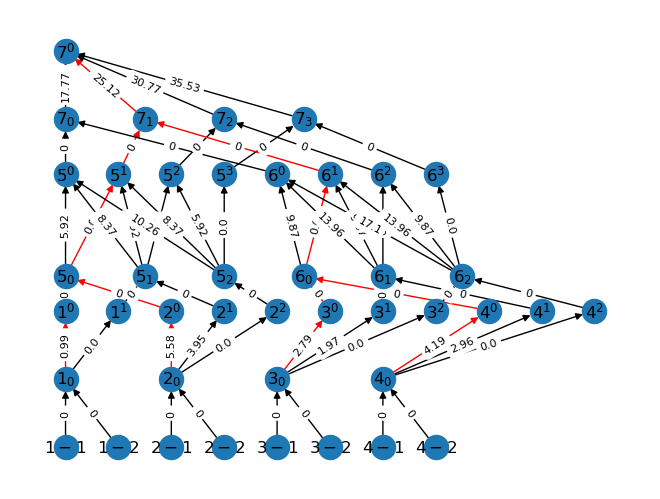

In [ ]:
edgesUsed = [(e[0], e[1]) for e in m._x if m._x[e].x > 0.0]
edge_colors = ['red' if edge in edgesUsed else 'black' 
               for edge in dp_G.edges()]
nx.draw(dp_G, pos, edge_color=edge_colors, 
        labels = node_labels, with_labels=True)
nx.draw_networkx_edge_labels(dp_G, pos, edge_labels=edge_labels, 
                             font_size=8)
plt.show()

In [ ]:
dp_G_multicommod = create_dp_graph(G, multi_commod = True)
nodeTypes = nx.get_node_attributes(dp_G_multicommod, 'nodeType')
commodityEdges = [(e[0], e[1], e[2]['commodity']) for e in dp_G_multicommod.edges(data = True)]

def getCommodityInEdgesForNode(G, node):
    return [(e[0], e[1], e[2]['commodity']) for e in G.in_edges(node, data = True)]

def getAllCommodityInEdges(G):
    edgeList = []
    for n in G.nodes():
        if nodeTypes[n] == 'multi-component':
            edgeList.extend(getCommodityInEdgesForNode(G, n))
    return edgeList

def getInEdgesForNode(G, node):
    return {e for e in G.in_edges(node)}

def getAllInEdges(G):
    edgeList = []
    for n in G.nodes():
        if nodeTypes[n] == 'multi-component':
            edgeList.extend(getInEdgesForNode(G, n))
    return edgeList

def getCommodityOutEdges(G, node):
    return [(e[0], e[1], e[2]['commodity']) for e in G.out_edges(node, data = True)]

KeyError: 'commodity'

In [ ]:
def handleGurobiStatus(m : gp.Model):
    status = m.status
    if status == GRB.Status.INFEASIBLE:
        print("The model is infeasible. Computing IIS.")
        m.computeIIS()
        m.write('iismodel.ilp')
        sys.exit(0)
    elif status == GRB.Status.UNBOUNDED:
        print("The model is unbounded.")
        sys.exit(0)
    elif status == GRB.Status.OPTIMAL:
        print("The model is optimal.")
    elif status == GRB.Status.INF_OR_UNBD:  
        print("The model status is infeasible or unbounded. Set DualReductions parameter to 0 and reoptimize.")
        sys.exit(0)
    else:
        print("The model status is neither infeasible nor unbounded.")
        sys.exit(0)

In [ ]:
def getNetFlowExpr(G, x, node):
    in_edges_sum = qsum(x[e] for e in getCommodityInEdgesForNode(G, node))
    out_edges_sum = qsum(x[e] for e in getCommodityOutEdges(G, node))
    return out_edges_sum - in_edges_sum

def getNetFlowExprWithCommod(G, x, node, commod):
    in_edges_sum = qsum(x[e] for e in getCommodityInEdgesForNode(G, node) if e[2] == commod)
    out_edges_sum = qsum(x[e] for e in getCommodityOutEdges(G, node) if e[2] == commod)
    return out_edges_sum - in_edges_sum

def getNetFlowExprRHS(n):
    if n in startNodes:
        return 1
    elif n == finalNodeStr:
        return -1
    else:
        return 0

def getOptimizedShortestPathModelMulticommodity(vtypeZ = GRB.BINARY, log = False):
    m = gp.Model("shortest_paths")
    m.Params.LogToConsole = log

    inEdges = getAllCommodityInEdges(dp_G_multicommod)
    flowEdges = [item for item in commodityEdges if item not in inEdges]

    edgeCostCommodity = {(e[0], e[1], e[2]['commodity']) : e[2]['cost'] 
                for e in dp_G_multicommod.edges(data = True)}
    
    edgeCost = {(e[0], e[1]) : e[2]['cost']
                for e in dp_G_multicommod.edges(data = True)}

    x = m.addVars(commodityEdges, name="x")
    y = m.addVars(inEdges, name="y")
    z = m.addVars(getAllInEdges(dp_G_multicommod), name="z", vtype=vtypeZ)
    m._x = x
    m._y = y
    m._z = z

    m.setObjective(qsum(edgeCostCommodity[e]*x[e] for e in flowEdges) + 
                qsum(z[e]*edgeCost[e] for e in z), 
                GRB.MINIMIZE)

    m.addConstrs((x[e] <= y[e] for e in y), "UB-y")
    m.addConstrs((y[e] <= z[e[0],e[1]] for c in components for e in y), 
                 "UB-z")
    multiNodes = [n for n in dp_G_multicommod.nodes() if nodeTypes[n] == 'multi-component']
    otherNodes = [n for n in dp_G_multicommod.nodes() if nodeTypes[n] == 'component']
    m.addConstrs((getNetFlowExpr(dp_G_multicommod, x, n) == getNetFlowExprRHS(n) 
                for n in otherNodes), "netflow")
    m.addConstrs((getNetFlowExprWithCommod(dp_G_multicommod, x, n, c) == getNetFlowExprRHS(n) 
                for n in multiNodes for c in components), "netflow-multi")
    m.optimize()
    m.write("multicommodity.lp")
    handleGurobiStatus(m)
    return m

m = getOptimizedShortestPathModelMulticommodity(vtypeZ = GRB.CONTINUOUS, log = False)
print("Relaxed Cost: $", format(m.ObjVal, ",.2f"))
for v in m.getVars():
    if v.x > 0:
        print('%s %g' % (v.varName, v.x))

The model is optimal.
Relaxed Cost: $ 38.67
x[7_1,7^0,1] 1
x[7_1,7^0,2] 1
x[7_1,7^0,3] 1
x[7_1,7^0,4] 1
x[5_0,5^1,1] 1
x[5_0,5^1,2] 1
x[5^1,7_1,1] 1
x[5^1,7_1,2] 1
x[1_0,1^0,1] 1
x[1^0,5_0,1] 1
x[2_0,2^0,2] 1
x[2^0,5_0,2] 1
x[6_0,6^1,3] 1
x[6_0,6^1,4] 1
x[6^1,7_1,3] 1
x[6^1,7_1,4] 1
x[3_0,3^0,3] 1
x[3^0,6_0,3] 1
x[4_0,4^0,4] 1
x[4^0,6_0,4] 1
y[5^1,7_1,1] 1
y[5^1,7_1,2] 1
y[6^1,7_1,3] 1
y[6^1,7_1,4] 1
y[7_1,7^0,1] 1
y[7_1,7^0,2] 1
y[7_1,7^0,3] 1
y[7_1,7^0,4] 1
y[1^0,5_0,1] 1
y[2^0,5_0,2] 1
y[5_0,5^1,1] 1
y[5_0,5^1,2] 1
y[3^0,6_0,3] 1
y[4^0,6_0,4] 1
y[6_0,6^1,3] 1
y[6_0,6^1,4] 1
z[5^1,7_1] 1
z[6^1,7_1] 1
z[7_1,7^0] 1
z[2^0,5_0] 1
z[1^0,5_0] 1
z[5_0,5^1] 1
z[3^0,6_0] 1
z[4^0,6_0] 1
z[6_0,6^1] 1


In [ ]:
m = getOptimizedShortestPathModelMulticommodity(log = False)
print("Optimal Cost: $", format(m.ObjVal, ",.2f"))

The model is optimal.
Optimal Cost: $ 38.67


In [ ]:
edgesUsed_multicommod = [e for e in m._x if m._x[e].x > 0.0]

In [ ]:
xVals = [m._x[e].x for e in m._x if m._x[e].x > 0.0]
edgesUsed = list({(e[0], e[1]) for e in m._x if m._x[e].x > 0.0})

costs = [dp_G.edges[e]['cost'] for e in edgesUsed]

df = pd.DataFrame({
    'Edge used': edgesUsed,
    'Holding cost': costs
})
df['Holding cost'] = df['Holding cost'].map('${:,.2f}'.format)
print("Cost: $", format(m.ObjVal, ",.2f"))
df

Cost: $ 38.67


,Edge used,Holding cost
0,"(4_0, 4^0)",$4.19
1,"(3^0, 6_0)",$0.00
2,"(5^1, 7_1)",$0.00
3,"(1_0, 1^0)",$0.99
4,"(3_0, 3^0)",$2.79
5,"(5_0, 5^1)",$0.00
6,"(7_1, 7^0)",$25.12
7,"(4^0, 6_0)",$0.00
8,"(6_0, 6^1)",$0.00
9,"(2^0, 5_0)",$0.00


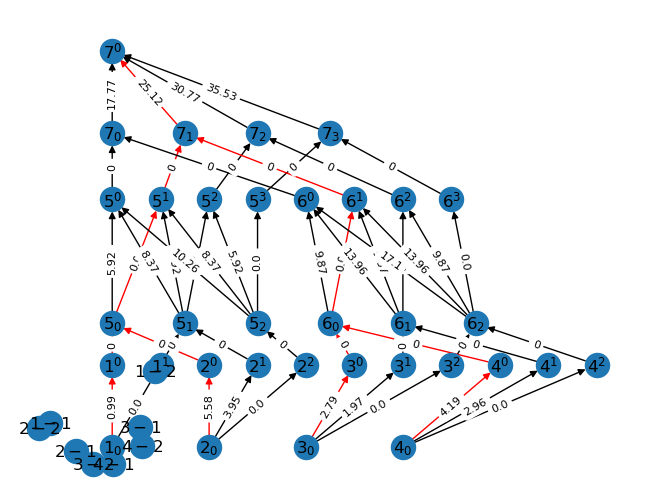

In [ ]:
edgesUsed = [(e[0], e[1]) for e in m._x if m._x[e].x > 0.0]
edge_colors = ['red' if edge in edgesUsed else 'black' 
               for edge in dp_G.edges()]
nx.draw(dp_G, pos, edge_color=edge_colors, 
        labels = node_labels, with_labels=True)
nx.draw_networkx_edge_labels(dp_G, pos, edge_labels=edge_labels, 
                             font_size=8)
plt.show()

## Solution: Inventory Held

In [ ]:
node_labels = {}
for n in G.nodes():
    for sIn in get_sIn_range_for_g_fn(n):
            for sOut in get_sOut_range_for_g_fn_forIn(n, sIn):
                nodeTupleIn = getNodeString(n, sIn, False)
                nodeTupleOut = getNodeString(n, sOut, True)
                if (nodeTupleIn, nodeTupleOut) in edgesUsed:
                    netTime = sIn + processTimesDict[n] - sOut
                    node_labels[n] = '{} ({})'.format(n, netTime)

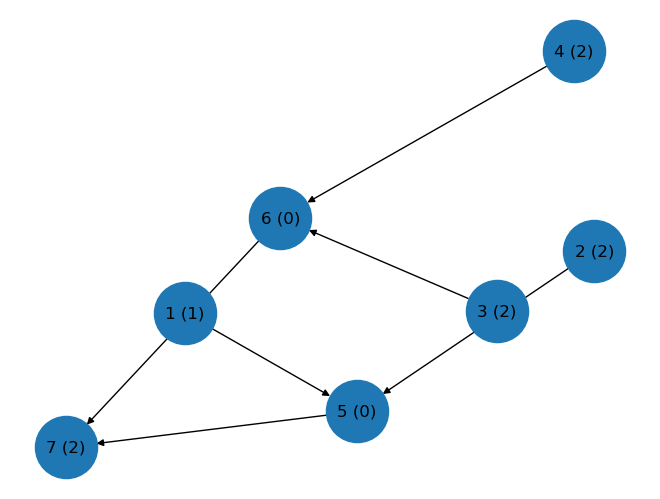

In [ ]:
pos = nx.spring_layout(G)
nx.draw(G, pos, labels = node_labels, with_labels=True, node_size=2000)
plt.show()